# Load modules

In [1]:
import numpy as np
import pandas as pd
from pipedream_solver.hydraulics import SuperLink
from pipedream_solver.simulation import Simulation
from pipedream_solver.nutils import interpolate_sample

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('husl')

# Load pipedream model information 

In [2]:
superjunctions = pd.read_csv('waller_superjunctions.csv', index_col=0)  
superlinks = pd.read_csv('waller_creek_superlinks.csv', index_col=0) 
subbasins = pd.read_excel('Waller_HMS_model_data.xlsx', sheet_name=0)

# Specify simulation parameters

In [3]:
# Unit conversions
m_per_ft = 0.3048
ft_per_mi = 5280.
in_per_ft = 12.
s_per_min = 60
ns_per_s = 1e9

# Manual edits to model
superlinks.loc[21, ['g2', 'g3']] = 0., 7.777146367746631
superlinks['C_uk'] = 0.
superlinks['C_dk'] = 0.

# Manual edits to hydrology params
lag_time_adjust_ratio = 0.4
CN_adjust_ratio = 1.0

# Simulation params
sample_interval = 30
start_date = '20220822'
end_date = '20220823'
node_ids = ['Bridge1','Bridge2','Bridge3','Bridge4','Bridge5']
site_junction_name = 'J_WLR18_COMB_HEMP'
site_link_name = 'R_WLR16'
site_junction_index = 14
site_link_index = 21

# Define runoff functions

In [4]:
def scs_composite_CN(CN_C, A_Imp):
    # Convert CN to composite CN given percent impervious area
    m = (99 - CN_C) / 100
    b = CN_C
    y = m * A_Imp + b
    return y

In [5]:
def scs_excess_precipitation(precip__in, CN): 
    # Set up SCS parameters
    P = precip__in.values
    S = 1000 / CN - 10
    Ia = 0.2 * S
    # Compute cumulative excess precipitation
    Pes = []
    P_now = 0
    n = len(P)
    for t in range(n):
        Pt = P[t]
        P_now = Pt + P_now
        if P_now <= Ia:
            Pe = 0.
        else:        
            Pe = (P_now - 0.2 * S)**2 / (P_now + 0.8 * S)
        Pes.append(Pe)
    # Assign time index to excess precipitation output
    excess_precip_cum__in = pd.Series(Pes, index=precip__in.index)
    return excess_precip_cum__in

In [6]:
def scs_uh_runoff(excess_precip__in, uh__dimless, area__sq_mi, sample_interval):
    # Give unit hydrograph a time dimension corresponding to lag time
    uh = uh__dimless.copy()
    uh_time = uh['time ratios'] * lag_time__min * s_per_min * ns_per_s
    uh_time = pd.to_datetime(uh_time.rename('time'))
    uh = uh.set_index(uh_time)['discharge ratios']
    # Resample unit hydrograph to desired time interval
    uh = uh.resample(f'{sample_interval}s').mean().interpolate()
    uh = uh.values    
    # Scale unit hydrograph to have area of unity
    uh_scaled = uh / uh.sum()
    
    # Convolve excess precipitation and unit hydrograph
    conv = np.convolve(excess_precip__in.values, uh_scaled)
    # Convert to outflow 
    area__sq_ft = area__sq_mi * (ft_per_mi)**2
    conv__ft = conv / in_per_ft
    runoff__cfs = (conv__ft * area__sq_ft) / sample_interval
    runoff__cms = runoff__cfs * (m_per_ft)**3
    time_index = pd.date_range(start=excess_precip__in.index.min(), 
                               periods=runoff__cms.size, 
                               freq=f'{sample_interval}s')
    # Return runoff in cubic meters per second
    runoff__cms = pd.Series(runoff__cms, index=time_index)
    return runoff__cms

# Load LCRA flow, depth, and precipitation data

In [7]:
# Add LCRA data (Flow, depth, and precipitation data for the 'Waller Creek at 23rd Street' gage from the LCRA site.)
LCRA = pd.read_excel('LCRA_discharge/W3A_Export.xlsx')
LCRA = LCRA[8:]
LCRA = LCRA.set_index('Site Name')
LCRA.index.name = 'Time'
# Handle timezone
LCRA = LCRA.tz_localize('US/Central', nonexistent='shift_forward').tz_convert('UTC')
# Rename columns to be more descriptive
LCRA = LCRA.rename(columns={'W3A' : 'depth__ft', 'W3A.1' : 'flow_rate__cfs', 'W3A.3' : 'precip_tot__in'})
LCRA = LCRA.drop('W3A.2', axis=1)
# Filter dataset to time period
LCRA = LCRA.loc[start_date:end_date]
# Compute dt for each time bin
LCRA['dt__s'] = np.roll(pd.Series(LCRA.index).diff(1).dt.seconds.values, -1)
# Compute precipitation rate from total inches and dt
LCRA['precip_rate__in_per_s'] = LCRA['precip_tot__in'] / LCRA['dt__s']

# Compute inches of precipitation for desired sample interval
precip__in = sample_interval * LCRA['precip_rate__in_per_s'].resample(f'{sample_interval}s').mean().interpolate()

# Load unit hydrograph

In [8]:
# Load dimensionless unit hydrograph
uh__dimless = pd.read_csv('unit hydrograph.csv')
# Drop unnecessary columns and rows
uh__dimless = uh__dimless[['time ratios', 'discharge ratios']].dropna()

# Load ultrasonic sensor data

In [9]:
# Create dict to store sensor time series
sensor_data = {}

# Load ultrasonic sensor data
for node_id in node_ids:
    node_data = pd.read_csv(f'{node_id}.csv', index_col=0).rename(columns={'0' : node_id})
    node_data.index = pd.to_datetime(node_data.index)
    node_data = node_data.loc[start_date:end_date]
    sensor_data[node_id] = node_data
    
# Create sensor data series for each bridge site
bridge2 = sensor_data['Bridge2']['Bridge2']
bridge3 = sensor_data['Bridge3']['Bridge3']
bridge4 = sensor_data['Bridge4']['Bridge4']
bridge5 = sensor_data['Bridge5']['Bridge5']

# Compute runoff into each superjunction

In [10]:
Q_in = {}
CNs = []
# For each subbasin...
for i in range(len(subbasins)):
    # Load subbasin parameters
    CN_C = subbasins.loc[i, 'Curve Number']
    A_Imp = subbasins.loc[i, 'Impervious Percent']
    area__sq_mi = subbasins.loc[i, 'Area (mi2)']
    downstream = subbasins.loc[i, 'Downstream']
    lag_time__min = subbasins.loc[i, 'Lag Time'] * lag_time_adjust_ratio
    
    # Compute composite curve number
    CN = scs_composite_CN(CN_C, A_Imp) * CN_adjust_ratio
    CN = min(CN, 99)

    # Compute excess precipitation
    excess_precip_cum__in = scs_excess_precipitation(precip__in, CN)
    excess_precip__in = -excess_precip_cum__in.diff(-1).fillna(0.)
    
    # Compute runoff using unit hydrograph
    runoff__cms = scs_uh_runoff(excess_precip__in, uh__dimless, area__sq_mi, sample_interval)
    Q_in[downstream] = runoff__cms
    
# Format flow input as DataFrame
Q_in = pd.DataFrame.from_dict(Q_in)
# Add flow input for missing sites
Q_in['UPSTREAM_WALLER'] = Q_in['R_WLR01']
Q_in['UPSTREAM_HEMPHILL'] = Q_in['R_HEM01']
Q_in[[name for name in superjunctions['name'] if not name in Q_in.columns]] = 0.
# Ensure flow input is only for superjunctions specified in table
Q_in = Q_in[superjunctions['name'].tolist()]
# Remove NaN values
Q_in = Q_in.fillna(0.)
# Copy flow input with original timestamps
Q_in_orig = Q_in.copy()
# Convert flow input index to integer index starting with zero
Q_in.index = Q_in.index.astype(int) / 1e9
Q_in.index -= Q_in.index.min()

# Run simulation without KF

In [11]:
superlink = SuperLink(superlinks, superjunctions,internal_links=30, mobile_elements=True)

H_j = []
h_Ik = []
Q_uk = []
Q_dk = []

# Set constant timestep (in seconds)
dt = 2

# Add constant baseflow
baseflow = 0.5e-4 * np.ones(superlink._h_Ik.size)

# Create simulation context manager
with Simulation(superlink, Q_in=Q_in) as simulation:
    # While simulation time has not expired...
    while simulation.t <= simulation.t_end:
        # Step model forward in time
        simulation.step(dt=dt, num_iter=8, Q_Ik=baseflow)
        simulation.model.reposition_junctions()
        # Print progress bar
        simulation.print_progress()
        # Save states
        H_j.append(simulation.model.H_j.copy())
        h_Ik.append(simulation.model.h_Ik.copy())
        Q_uk.append(simulation.model.Q_uk.copy())
        Q_dk.append(simulation.model.Q_dk.copy())

[==================================================] 100.0% [20.08 s]

# Gather simulation output data

In [12]:
# Compute the time index of the saved output data
time_index = pd.date_range(start=excess_precip__in.index.min(), 
                           periods=len(H_j), 
                           freq=f'{dt}s')

# Convert saved states to dataframes
H_j = pd.DataFrame(np.vstack(H_j), index=time_index, columns=superjunctions['name'])
h_Ik = pd.DataFrame(np.vstack(h_Ik), index=time_index)
Q_uk = pd.DataFrame(np.vstack(Q_uk), index=time_index, columns=superlinks['name'])
Q_dk = pd.DataFrame(np.vstack(Q_dk), index=time_index, columns=superlinks['name'])

# Compute depth
h_j = H_j - simulation.model._z_inv_j

# Plot simulation depth output against sensor data

Text(0.5, 1.0, 'Depth comparison')

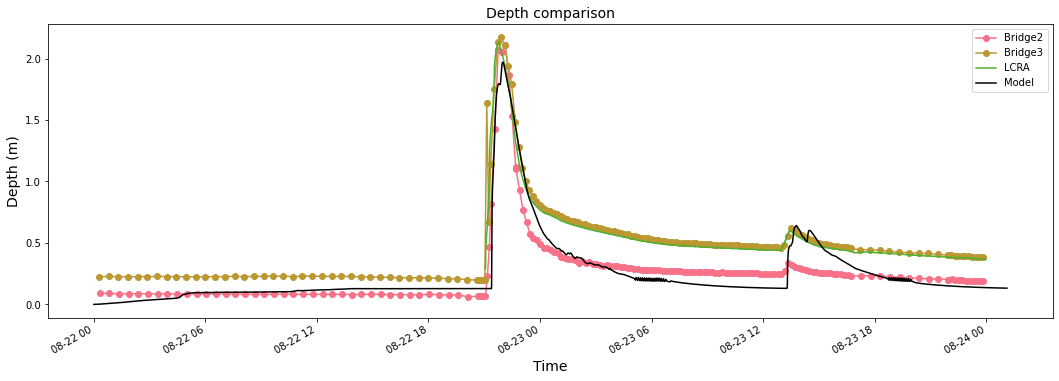

In [13]:
fig, ax = plt.subplots(figsize=(18, 6))
bridge2.plot(ax=ax, label='Bridge2', marker='o')
bridge3.plot(ax=ax, label='Bridge3', marker='o')
(m_per_ft * LCRA['depth__ft']).plot(ax=ax, label='LCRA')
h_j[site_junction_name].plot(ax=ax, label='Model', c='k', zorder=3)
plt.legend()
plt.xlabel('Time', size=14)
plt.ylabel('Depth (m)', size=14)
plt.title('Depth comparison', size=14)

# Plot simulation flow output against sensor data

Text(0.5, 1.0, 'Flow rate comparison')

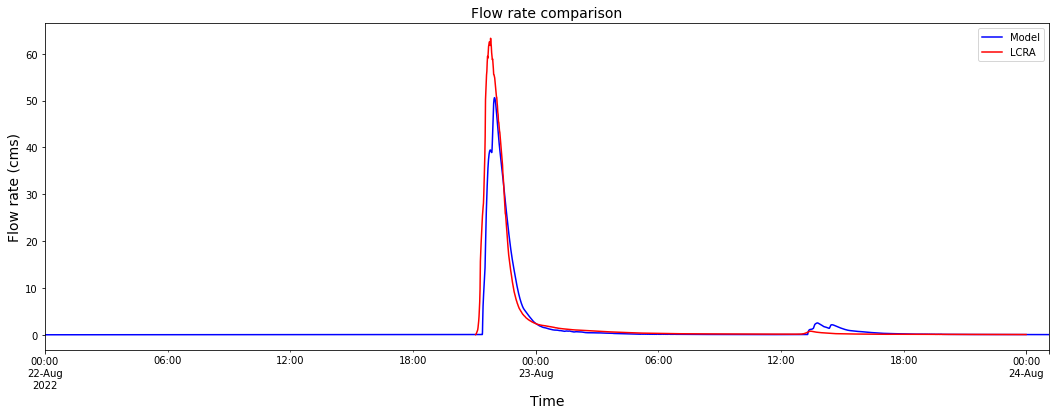

In [14]:
fig, ax = plt.subplots(figsize=(18, 6))
(Q_uk[site_link_name]).plot(ax=ax, label='Model', c='b')
(m_per_ft**3 * LCRA['flow_rate__cfs']).plot(ax=ax, label='LCRA', c='r')
plt.legend()
plt.xlabel('Time', size=14)
plt.ylabel('Flow rate (cms)', size=14)
plt.title('Flow rate comparison', size=14)

# Plot observed vs. modeled depth-discharge relationship

Text(0, 0.5, 'Discharge')

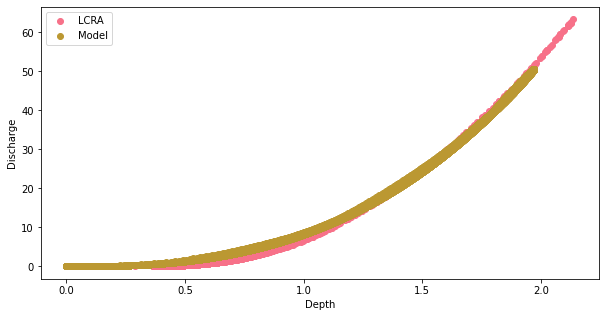

In [15]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.scatter(m_per_ft * LCRA['depth__ft'], m_per_ft**3 * LCRA['flow_rate__cfs'], label='LCRA')
plt.scatter(h_j[site_junction_name], Q_uk[site_link_name].values, label='Model')
plt.legend()
plt.xlabel('Depth')
plt.ylabel('Discharge')

# Initialize parameters for KF

In [16]:
# Instantiate new model
superlink = SuperLink(superlinks, superjunctions, internal_links=30)

# Set up Kalman filtering parameters
n = superlink.M
p = n
m = 1

process_std_dev = 1e-2
measurement_std_dev = 2e-4

H_kal = np.zeros((m, n))
H_kal[0, 14] = 1.
Qcov = (process_std_dev**2)*np.eye(p)
Rcov = (measurement_std_dev**2)*np.eye(m)

C_kal = np.zeros((n, p))
C_kal[np.arange(n), np.arange(p)] = 1.

# Define measurement inputs for KF

In [17]:
# Convert depth measurements to head by adding invert elevation
measurements = pd.DataFrame(bridge2 + superlink._z_inv_j[site_junction_index])
# Convert time index to integer index (seconds since start of simulation)
measurements.index = measurements.index - Q_in_orig.index.min()
measurements.index = measurements.index.astype(int) / 1e9

# Run simulation with KF

In [18]:
# Set initial, end, minimum and maximum timesteps
dt = 5
min_dt = 2
max_dt = 10
t_end = Q_in.index[-1]

H_j_filtered = []
Q_uk_filtered = []

# Create simulation context manager
with Simulation(superlink, Q_in=Q_in, Qcov=Qcov, Rcov=Rcov,
                C=C_kal, H=H_kal, interpolation_method='nearest') as filtered_simulation:
    # While simulation time has not expired...
    for step in filtered_simulation.steps:
        if filtered_simulation.t >= filtered_simulation.t_end:
            break
        # Step model forward in time
        filtered_simulation.step(dt=dt, subdivisions=1)
        filtered_simulation.model.superlink_inverse_courant()
        # Get measured value
        next_measurement = interpolate_sample(filtered_simulation.t,
                                              measurements.index.values,
                                              measurements.values)
        # Apply Kalman filter with measured value
        filtered_simulation.kalman_filter(next_measurement, dt=dt)
        # Adjust step size using inverse courant number
        dt = min(max(superlink._dt_ck.min(), min_dt), max_dt)
        # Record internal depth and flow states
        filtered_simulation.record_state()
        # Print progress bar
        filtered_simulation.print_progress()

[==================================================] 100.0% [7.18 s]

# Gather KF outputs

In [19]:
h_j_filtered = (filtered_simulation.states.H_j - filtered_simulation.model._z_inv_j)
h_j_filtered.index = pd.to_timedelta(h_j_filtered.index * ns_per_s) + Q_in_orig.index.min()

# Plot model and KF results against sensor

Text(0, 0.5, 'Depth (m)')

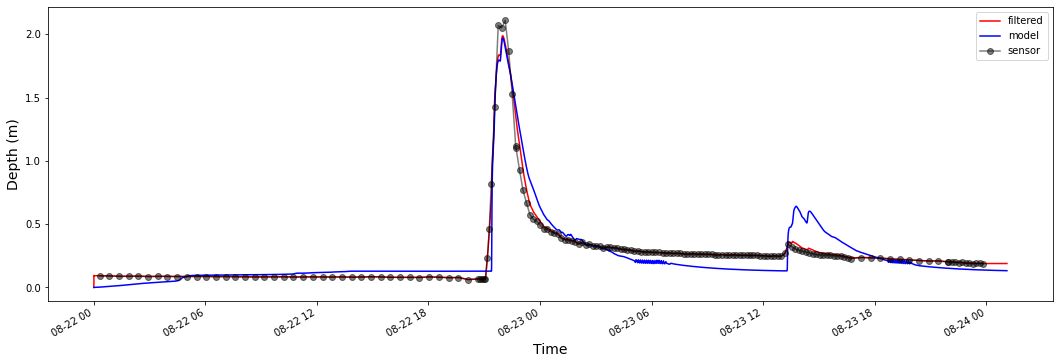

In [20]:
fig, ax = plt.subplots(figsize=(18, 6))
h_j_filtered[site_junction_name].plot(label='filtered', c='r')
h_j[site_junction_name].plot(label='model', c='b')
bridge2.plot(label='sensor', marker='o', c='k', alpha=0.5)
plt.legend()
plt.xlabel('Time', size=14)
plt.ylabel('Depth (m)', size=14)